In [ ]:
# Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Paths
RAW_DATA_PATH = Path("../data/raw")
PROCESSED_DATA_PATH = Path("../data/processed")
PROCESSED_DATA_PATH.mkdir(exist_ok=True, parents=True)

print("✅ Setup complete")

: 

In [316]:
# Load Sample Data
week = "01"

input_df = pd.read_csv(RAW_DATA_PATH / f"input_2023_w{week}.csv")
output_df = pd.read_csv(RAW_DATA_PATH / f"output_2023_w{week}.csv")
supp_df = pd.read_csv(RAW_DATA_PATH / "supplementary_data.csv")

# Merge
df = input_df.merge(supp_df, on=['game_id', 'play_id'], how='left')

print(f"Loaded {len(df):,} rows, {df['game_id'].nunique()} games, "
      f"{df[['game_id', 'play_id']].drop_duplicates().shape[0]} plays")

Loaded 285,714 rows, 16 games, 819 plays


In [317]:
# Define Prediction Problem
print("=" * 80)
print("PREDICTION PROBLEM DEFINITION")
print("=" * 80)
print("""
TARGET:
  - Predict future (x, y) positions for each player over `num_frames_output` frames
  - Granularity: Per player, per frame after the pass is thrown
  
INPUT FEATURES:
  - Pre-throw tracking data (position, velocity, acceleration, orientation)
  - Player attributes (position, role, height, weight)
  - Play context (coverage, formation, down/distance, field position)
  - Relative features (distances, angles to key players/locations)
  
APPROACH:
  1. Engineer features at the frame level (kinematics, relative positions)
  2. Aggregate play-level context features
  3. Create sequence features for temporal models (LSTM, Transformer)
""")

PREDICTION PROBLEM DEFINITION

TARGET:
  - Predict future (x, y) positions for each player over `num_frames_output` frames
  - Granularity: Per player, per frame after the pass is thrown

INPUT FEATURES:
  - Pre-throw tracking data (position, velocity, acceleration, orientation)
  - Player attributes (position, role, height, weight)
  - Play context (coverage, formation, down/distance, field position)
  - Relative features (distances, angles to key players/locations)

APPROACH:
  1. Engineer features at the frame level (kinematics, relative positions)
  2. Aggregate play-level context features
  3. Create sequence features for temporal models (LSTM, Transformer)



In [318]:
# Feature Engineering - Kinematics
def add_kinematic_features(df):
    """Add smoothed speed, acceleration, jerk, and turn rate"""
    
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id']).copy()
    
    # Smoothed speed and acceleration (rolling mean over 3 frames)
    df['s_smooth'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['s'].transform(
        lambda x: x.rolling(window=3, min_periods=1, center=True).mean()
    )
    df['a_smooth'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['a'].transform(
        lambda x: x.rolling(window=3, min_periods=1, center=True).mean()
    )
    
    # Jerk (rate of change of acceleration)
    df['jerk'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['a'].diff()
    
    # Turn rate (change in direction)
    df['dir_change'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['dir'].diff()
    # Handle wraparound (e.g., 359° to 1° should be 2°, not -358°)
    df['dir_change'] = df['dir_change'].apply(
        lambda x: x - 360 if x > 180 else (x + 360 if x < -180 else x)
    )
    
    # Bearing difference (difference between orientation and direction)
    df['bearing_diff'] = df['o'] - df['dir']
    df['bearing_diff'] = df['bearing_diff'].apply(
        lambda x: x - 360 if x > 180 else (x + 360 if x < -180 else x)
    )
    
    return df

# Apply
df = add_kinematic_features(df)

print("✅ Kinematic features added:")
print("  - s_smooth, a_smooth (rolling mean)")
print("  - jerk (rate of change of acceleration)")
print("  - dir_change (turn rate)")
print("  - bearing_diff (orientation vs direction)")

✅ Kinematic features added:
  - s_smooth, a_smooth (rolling mean)
  - jerk (rate of change of acceleration)
  - dir_change (turn rate)
  - bearing_diff (orientation vs direction)


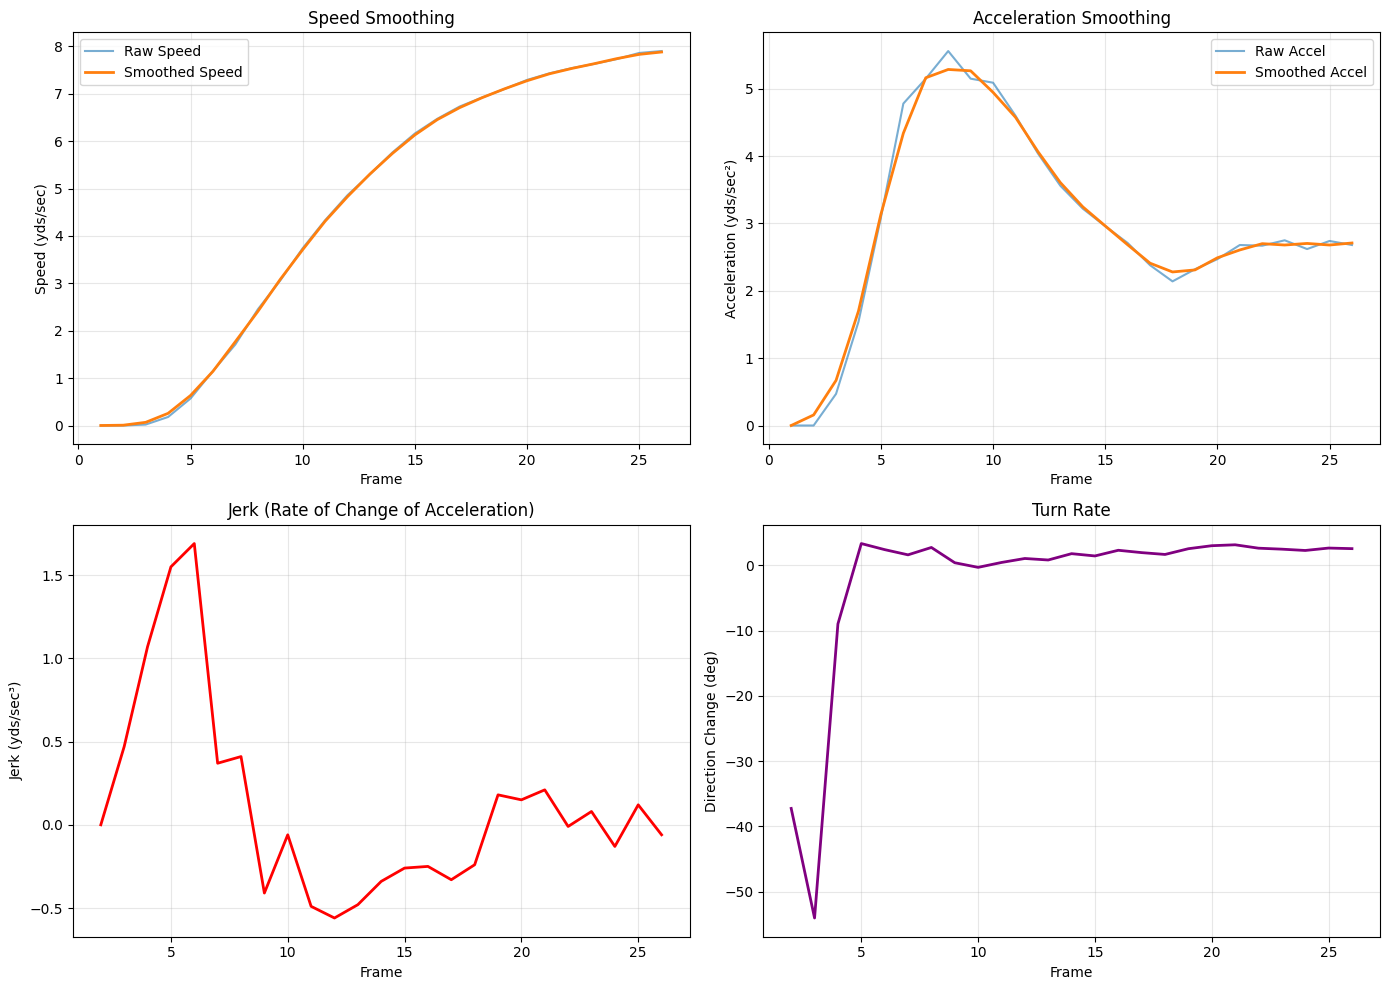

In [319]:
# Visualize Kinematic Features
sample_player = df[df['player_to_predict'] == True].iloc[0]
sample_data = df[
    (df['game_id'] == sample_player['game_id']) &
    (df['play_id'] == sample_player['play_id']) &
    (df['nfl_id'] == sample_player['nfl_id'])
].sort_values('frame_id')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Speed
axes[0, 0].plot(sample_data['frame_id'], sample_data['s'], label='Raw Speed', alpha=0.6)
axes[0, 0].plot(sample_data['frame_id'], sample_data['s_smooth'], label='Smoothed Speed', linewidth=2)
axes[0, 0].set_xlabel('Frame')
axes[0, 0].set_ylabel('Speed (yds/sec)')
axes[0, 0].set_title('Speed Smoothing')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Acceleration
axes[0, 1].plot(sample_data['frame_id'], sample_data['a'], label='Raw Accel', alpha=0.6)
axes[0, 1].plot(sample_data['frame_id'], sample_data['a_smooth'], label='Smoothed Accel', linewidth=2)
axes[0, 1].set_xlabel('Frame')
axes[0, 1].set_ylabel('Acceleration (yds/sec²)')
axes[0, 1].set_title('Acceleration Smoothing')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Jerk
axes[1, 0].plot(sample_data['frame_id'], sample_data['jerk'], color='red', linewidth=2)
axes[1, 0].set_xlabel('Frame')
axes[1, 0].set_ylabel('Jerk (yds/sec³)')
axes[1, 0].set_title('Jerk (Rate of Change of Acceleration)')
axes[1, 0].grid(True, alpha=0.3)

# Direction change
axes[1, 1].plot(sample_data['frame_id'], sample_data['dir_change'], color='purple', linewidth=2)
axes[1, 1].set_xlabel('Frame')
axes[1, 1].set_ylabel('Direction Change (deg)')
axes[1, 1].set_title('Turn Rate')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Path("../visualizations") / "09_kinematic_features.png", dpi=300, bbox_inches='tight')
plt.show()

In [320]:
# Feature Engineering - Relative Positions
def add_relative_position_features(df):
    """Add distances and angles to key locations and players"""
    
    df = df.copy()
    
    # Distance to ball landing spot
    df['dist_to_ball_land'] = np.sqrt(
        (df['x'] - df['ball_land_x'])**2 + 
        (df['y'] - df['ball_land_y'])**2
    )
    
    # Angle to ball landing spot
    df['angle_to_ball_land'] = np.arctan2(
        df['ball_land_y'] - df['y'],
        df['ball_land_x'] - df['x']
    ) * 180 / np.pi
    
    # For each play, find QB, targeted receiver, and calculate distances
    def calc_player_distances(group):
        # Find QB (Passer)
        qb = group[group['player_role'] == 'Passer']
        if len(qb) > 0:
            qb_x, qb_y = qb['x'].iloc[0], qb['y'].iloc[0]
            group['dist_to_qb'] = np.sqrt((group['x'] - qb_x)**2 + (group['y'] - qb_y)**2)
        else:
            group['dist_to_qb'] = np.nan
        
        # Find targeted receiver
        target = group[group['player_role'] == 'Targeted Receiver']
        if len(target) > 0:
            target_x, target_y = target['x'].iloc[0], target['y'].iloc[0]
            group['dist_to_target'] = np.sqrt((group['x'] - target_x)**2 + (group['y'] - target_y)**2)
        else:
            group['dist_to_target'] = np.nan
        
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_player_distances)
    
    # Distance to sidelines
    df['dist_to_left_sideline'] = df['y']
    df['dist_to_right_sideline'] = 53.3 - df['y']
    df['dist_to_nearest_sideline'] = df[['dist_to_left_sideline', 'dist_to_right_sideline']].min(axis=1)
    
    # Distance to end zones
    df['dist_to_own_endzone'] = df.apply(
        lambda row: row['x'] if row['play_direction'] == 'right' else 120 - row['x'],
        axis=1
    )
    df['dist_to_opp_endzone'] = 120 - df['dist_to_own_endzone']
    
    return df

# Apply
df = add_relative_position_features(df)

print("✅ Relative position features added:")
print("  - dist_to_ball_land, angle_to_ball_land")
print("  - dist_to_qb, dist_to_target")
print("  - dist_to_nearest_sideline")
print("  - dist_to_own_endzone, dist_to_opp_endzone")

✅ Relative position features added:
  - dist_to_ball_land, angle_to_ball_land
  - dist_to_qb, dist_to_target
  - dist_to_nearest_sideline
  - dist_to_own_endzone, dist_to_opp_endzone


In [321]:
# Feature Engineering - Coverage & Separation
def add_coverage_features(df):
    """Add separation metrics for coverage analysis"""
    
    df = df.copy()
    
    # For each frame, calculate nearest offensive and defensive player
    def calc_nearest_players(group):
        offense = group[group['player_side'] == 'Offense'][['x', 'y', 'nfl_id']].values
        defense = group[group['player_side'] == 'Defense'][['x', 'y', 'nfl_id']].values
        
        # For each player, find nearest opponent
        nearest_opp_dist = []
        for _, row in group.iterrows():
            if row['player_side'] == 'Offense':
                opponents = defense
            else:
                opponents = offense
            
            if len(opponents) > 0:
                distances = [euclidean([row['x'], row['y']], opp[:2]) for opp in opponents]
                nearest_opp_dist.append(min(distances))
            else:
                nearest_opp_dist.append(np.nan)
        
        group['nearest_opponent_dist'] = nearest_opp_dist
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_nearest_players)
    
    # Separation for targeted receiver (distance to nearest defender)
    def calc_receiver_separation(group):
        target = group[group['player_role'] == 'Targeted Receiver']
        if len(target) > 0:
            target_x, target_y = target['x'].iloc[0], target['y'].iloc[0]
            defenders = group[group['player_side'] == 'Defense']
            if len(defenders) > 0:
                defender_dists = np.sqrt((defenders['x'] - target_x)**2 + (defenders['y'] - target_y)**2)
                min_separation = defender_dists.min()
                group['receiver_separation'] = min_separation
            else:
                group['receiver_separation'] = np.nan
        else:
            group['receiver_separation'] = np.nan
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_receiver_separation)
    
    # Player density (count within 5-yard radius)
    def calc_density(group):
        densities = []
        for _, row in group.iterrows():
            others = group[group['nfl_id'] != row['nfl_id']]
            distances = np.sqrt((others['x'] - row['x'])**2 + (others['y'] - row['y'])**2)
            density = (distances <= 5).sum()
            densities.append(density)
        group['player_density_5yd'] = densities
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_density)
    
    return df

# Apply (this may take a minute)
print("⏳ Calculating coverage features (this may take a minute)...")
df = add_coverage_features(df)

print("✅ Coverage features added:")
print("  - nearest_opponent_dist")
print("  - receiver_separation")
print("  - player_density_5yd")

⏳ Calculating coverage features (this may take a minute)...
✅ Coverage features added:
  - nearest_opponent_dist
  - receiver_separation
  - player_density_5yd


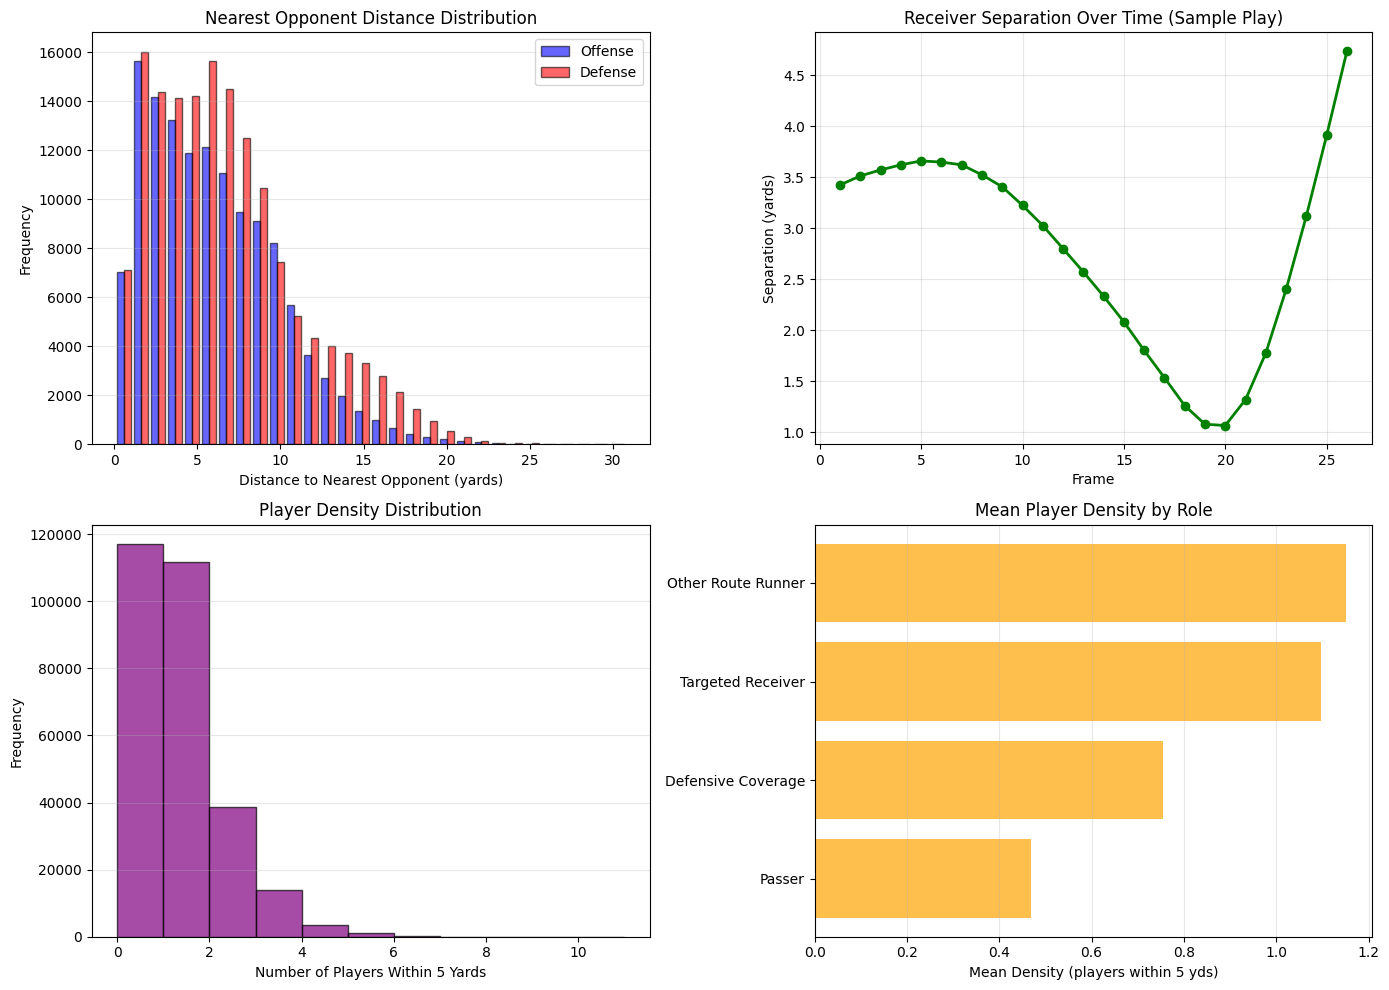

In [322]:
# Visualize Coverage Features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Nearest opponent distance by side
offense_dist = df[df['player_side'] == 'Offense']['nearest_opponent_dist'].dropna()
defense_dist = df[df['player_side'] == 'Defense']['nearest_opponent_dist'].dropna()
axes[0, 0].hist([offense_dist, defense_dist], bins=30, label=['Offense', 'Defense'], 
                color=['blue', 'red'], alpha=0.6, edgecolor='black')
axes[0, 0].set_xlabel('Distance to Nearest Opponent (yards)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Nearest Opponent Distance Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Receiver separation over time (sample play)
sample_play = df[df['receiver_separation'].notna()][['game_id', 'play_id']].drop_duplicates().iloc[0]
play_data = df[(df['game_id'] == sample_play['game_id']) & (df['play_id'] == sample_play['play_id'])]
play_data = play_data.groupby('frame_id')['receiver_separation'].first().reset_index()
axes[0, 1].plot(play_data['frame_id'], play_data['receiver_separation'], 
                color='green', linewidth=2, marker='o')
axes[0, 1].set_xlabel('Frame')
axes[0, 1].set_ylabel('Separation (yards)')
axes[0, 1].set_title('Receiver Separation Over Time (Sample Play)')
axes[0, 1].grid(True, alpha=0.3)

# Player density distribution
axes[1, 0].hist(df['player_density_5yd'], bins=range(0, 12), 
                color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Number of Players Within 5 Yards')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Player Density Distribution')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Density by player role
role_density = df.groupby('player_role')['player_density_5yd'].mean().sort_values()
axes[1, 1].barh(role_density.index, role_density.values, color='orange', alpha=0.7)
axes[1, 1].set_xlabel('Mean Density (players within 5 yds)')
axes[1, 1].set_title('Mean Player Density by Role')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(Path("../visualizations") / "11_coverage_features.png", dpi=300, bbox_inches='tight')
plt.show()

In [323]:
# Feature Engineering - Play Context
def add_play_context_features(df):
    """Add encoded play-level contextual features"""
    
    df = df.copy()
    
    # Encode categorical features
    categorical_cols = [
        'team_coverage_man_zone', 'team_coverage_type', 'dropback_type',
        'route_of_targeted_receiver', 'offense_formation', 'pass_result',
        'player_position', 'player_role', 'player_side'
    ]
    
    label_encoders = {}
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
    
    # Situational features
    df['score_differential'] = df['pre_snap_home_score'] - df['pre_snap_visitor_score']
    
    # Field position (normalized to 0-1, where 1 is opponent's goal line)
    df['field_position_norm'] = df['absolute_yardline_number'] / 100
    
    # Down & distance features
    df['yards_to_go_norm'] = df['yards_to_go'] / 10  # Normalize by first down distance
    df['down_distance_ratio'] = df['yards_to_go'] / (df['down'] + 1)  # Avoid div by 0
    
    # Time features (convert game_clock MM:SS to seconds)
    if 'game_clock' in df.columns:
        df['game_clock_seconds'] = df['game_clock'].apply(
            lambda x: int(str(x).split(':')[0]) * 60 + int(str(x).split(':')[1]) if pd.notna(x) and ':' in str(x) else np.nan
        )
    
    # Play action indicator
    if 'play_action' in df.columns:
        df['play_action_binary'] = df['play_action'].map({'True': 1, 'False': 0})
    
    return df, label_encoders

# Apply
df, label_encoders = add_play_context_features(df)

print("✅ Play context features added:")
print("  - Encoded categorical features (coverage, formation, route, etc.)")
print("  - score_differential")
print("  - field_position_norm")
print("  - yards_to_go_norm, down_distance_ratio")
print("  - game_clock_seconds")
print("  - play_action_binary")

✅ Play context features added:
  - Encoded categorical features (coverage, formation, route, etc.)
  - score_differential
  - field_position_norm
  - yards_to_go_norm, down_distance_ratio
  - game_clock_seconds
  - play_action_binary


In [324]:
# ============================================================================
# CREATE ENHANCED FEATURE ENGINEERING MODULE
# ============================================================================
# This code will be moved to src/feature_engineering.py

feature_engineering_code = '''
"""
Feature engineering functions for NFL Big Data Bowl
Enhanced with game situation, route intelligence, and velocity/momentum features
"""

import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import LabelEncoder


# ============================================================================
# KINEMATIC FEATURES
# ============================================================================

def add_kinematic_features(df):
    """Add smoothed speed, acceleration, jerk, and turn rate"""
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id']).copy()
    
    df['s_smooth'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['s'].transform(
        lambda x: x.rolling(window=3, min_periods=1, center=True).mean()
    )
    df['a_smooth'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['a'].transform(
        lambda x: x.rolling(window=3, min_periods=1, center=True).mean()
    )
    df['jerk'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['a'].diff()
    df['dir_change'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['dir'].diff()
    df['dir_change'] = df['dir_change'].apply(
        lambda x: x - 360 if x > 180 else (x + 360 if x < -180 else x)
    )
    df['bearing_diff'] = df['o'] - df['dir']
    df['bearing_diff'] = df['bearing_diff'].apply(
        lambda x: x - 360 if x > 180 else (x + 360 if x < -180 else x)
    )
    
    return df


# ============================================================================
# RELATIVE POSITION FEATURES
# ============================================================================

def add_relative_position_features(df):
    """Add distances and angles to key locations and players"""
    df = df.copy()
    
    # Distance and angle to ball landing position
    df['dist_to_ball_land'] = np.sqrt(
        (df['x'] - df['ball_land_x'])**2 + (df['y'] - df['ball_land_y'])**2
    )
    df['angle_to_ball_land'] = np.arctan2(
        df['ball_land_y'] - df['y'], df['ball_land_x'] - df['x']
    ) * 180 / np.pi
    
    # Distance to QB and target receiver
    def calc_player_distances(group):
        qb = group[group['player_role'] == 'Passer']
        if len(qb) > 0:
            qb_x, qb_y = qb['x'].iloc[0], qb['y'].iloc[0]
            group['dist_to_qb'] = np.sqrt((group['x'] - qb_x)**2 + (group['y'] - qb_y)**2)
        else:
            group['dist_to_qb'] = np.nan
        
        target = group[group['player_role'] == 'Targeted Receiver']
        if len(target) > 0:
            target_x, target_y = target['x'].iloc[0], target['y'].iloc[0]
            group['dist_to_target'] = np.sqrt((group['x'] - target_x)**2 + (group['y'] - target_y)**2)
        else:
            group['dist_to_target'] = np.nan
        
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_player_distances)
    
    # Distance to sidelines
    df['dist_to_left_sideline'] = df['y']
    df['dist_to_right_sideline'] = 53.3 - df['y']
    df['dist_to_nearest_sideline'] = df[['dist_to_left_sideline', 'dist_to_right_sideline']].min(axis=1)
    
    # Distance to endzones
    df['dist_to_own_endzone'] = df.apply(
        lambda row: row['x'] if row['play_direction'] == 'right' else 120 - row['x'], axis=1
    )
    df['dist_to_opp_endzone'] = 120 - df['dist_to_own_endzone']
    
    return df


# ============================================================================
# COVERAGE FEATURES
# ============================================================================

def add_coverage_features(df):
    """Add separation metrics for coverage analysis"""
    df = df.copy()
    
    # Nearest opponent distance
    def calc_nearest_players(group):
        offense = group[group['player_side'] == 'Offense'][['x', 'y', 'nfl_id']].values
        defense = group[group['player_side'] == 'Defense'][['x', 'y', 'nfl_id']].values
        
        nearest_opp_dist = []
        for _, row in group.iterrows():
            if row['player_side'] == 'Offense':
                opponents = defense
            else:
                opponents = offense
            
            if len(opponents) > 0:
                distances = [euclidean([row['x'], row['y']], opp[:2]) for opp in opponents]
                nearest_opp_dist.append(min(distances))
            else:
                nearest_opp_dist.append(np.nan)
        
        group['nearest_opponent_dist'] = nearest_opp_dist
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_nearest_players)
    
    # Receiver separation
    def calc_receiver_separation(group):
        target = group[group['player_role'] == 'Targeted Receiver']
        if len(target) > 0:
            target_x, target_y = target['x'].iloc[0], target['y'].iloc[0]
            defenders = group[group['player_side'] == 'Defense']
            if len(defenders) > 0:
                defender_dists = np.sqrt((defenders['x'] - target_x)**2 + (defenders['y'] - target_y)**2)
                min_separation = defender_dists.min()
                group['receiver_separation'] = min_separation
            else:
                group['receiver_separation'] = np.nan
        else:
            group['receiver_separation'] = np.nan
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_receiver_separation)
    
    # Player density
    def calc_density(group):
        densities = []
        for _, row in group.iterrows():
            others = group[group['nfl_id'] != row['nfl_id']]
            distances = np.sqrt((others['x'] - row['x'])**2 + (others['y'] - row['y'])**2)
            density = (distances <= 5).sum()
            densities.append(density)
        group['player_density_5yd'] = densities
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_density)
    
    return df


# ============================================================================
# PLAY CONTEXT FEATURES
# ============================================================================

def add_play_context_features(df):
    """Add encoded play-level contextual features"""
    df = df.copy()
    
    # Encode categorical variables
    categorical_cols = [
        'team_coverage_man_zone', 'team_coverage_type', 'dropback_type',
        'route_of_targeted_receiver', 'offense_formation', 'pass_result',
        'player_position', 'player_role', 'player_side'
    ]
    
    label_encoders = {}
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
    
    # Numerical context features
    df['score_differential'] = df['pre_snap_home_score'] - df['pre_snap_visitor_score']
    df['field_position_norm'] = df['absolute_yardline_number'] / 100
    df['yards_to_go_norm'] = df['yards_to_go'] / 10
    df['down_distance_ratio'] = df['yards_to_go'] / (df['down'] + 1)
    
    # Game clock
    if 'game_clock' in df.columns:
        df['game_clock_seconds'] = df['game_clock'].apply(
            lambda x: int(str(x).split(':')[0]) * 60 + int(str(x).split(':')[1]) 
            if pd.notna(x) and ':' in str(x) else np.nan
        )
    
    # Play action
    if 'play_action' in df.columns:
        df['play_action_binary'] = df['play_action'].map({'True': 1, 'False': 0})
    
    return df, label_encoders


# ============================================================================
# GAME SITUATION FEATURES (✨ NEW ✨)
# ============================================================================

def add_game_situation_features(df):
    """
    Add advanced game situation features based on game context
    
    Features:
    - Time pressure indicators (2-minute drill, end of quarter)
    - Score pressure categories (winning big, close game, losing)
    - Critical down situations (3rd/4th down, long distance)
    - Red zone indicators
    - Field position categories
    """
    df = df.copy()
    
    # ===== TIME PRESSURE FEATURES =====
    if 'game_clock_seconds' not in df.columns and 'game_clock' in df.columns:
        df['game_clock_seconds'] = df['game_clock'].apply(
            lambda x: int(str(x).split(':')[0]) * 60 + int(str(x).split(':')[1]) 
            if pd.notna(x) and ':' in str(x) else np.nan
        )
    
    # Two-minute warning
    df['two_minute_drill'] = (
        ((df['quarter'] == 2) | (df['quarter'] == 4)) & 
        (df['game_clock_seconds'] <= 120)
    ).astype(int)
    
    # End of quarter pressure
    df['end_of_quarter'] = (df['game_clock_seconds'] <= 300).astype(int)
    
    # Time remaining normalized
    df['time_remaining_norm'] = (
        (df['quarter'] - 1) * 900 + df['game_clock_seconds']
    ) / 3600
    
    # ===== SCORE PRESSURE FEATURES =====
    if 'score_differential' not in df.columns:
        df['score_differential'] = df['pre_snap_home_score'] - df['pre_snap_visitor_score']
    
    # Adjust for possession team perspective
    df['score_diff_possession'] = df.apply(
        lambda row: row['score_differential'] 
        if row['possession_team'] == row['home_team_abbr'] 
        else -row['score_differential'],
        axis=1
    )
    
    # Score pressure categories
    def categorize_score_pressure(diff):
        if diff >= 17: return 'winning_big'
        elif diff >= 7: return 'winning_comfortable'
        elif diff >= 3: return 'winning_close'
        elif diff >= -3: return 'tied_close'
        elif diff >= -7: return 'losing_close'
        elif diff >= -17: return 'losing_comfortable'
        else: return 'losing_big'
    
    df['score_pressure_category'] = df['score_diff_possession'].apply(categorize_score_pressure)
    
    # Binary indicators
    df['is_winning'] = (df['score_diff_possession'] > 0).astype(int)
    df['is_close_game'] = (df['score_diff_possession'].abs() <= 7).astype(int)
    df['is_blowout'] = (df['score_diff_possession'].abs() >= 17).astype(int)
    
    # ===== DOWN & DISTANCE FEATURES =====
    df['third_down_long'] = ((df['down'] == 3) & (df['yards_to_go'] >= 7)).astype(int)
    df['fourth_down'] = (df['down'] == 4).astype(int)
    df['passing_down'] = (
        ((df['down'] == 2) & (df['yards_to_go'] >= 8)) |
        ((df['down'] == 3) & (df['yards_to_go'] >= 5))
    ).astype(int)
    df['short_yardage'] = ((df['down'].isin([3, 4])) & (df['yards_to_go'] <= 2)).astype(int)
    
    # Down category
    df['down_category'] = df['down'].map({
        1: 'first_down', 2: 'second_down', 3: 'third_down', 4: 'fourth_down'
    })
    
    # Distance category
    def categorize_distance(yards):
        if yards <= 3: return 'short'
        elif yards <= 7: return 'medium'
        else: return 'long'
    
    df['distance_category'] = df['yards_to_go'].apply(categorize_distance)
    
    # ===== FIELD POSITION FEATURES =====
    df['red_zone'] = (df['absolute_yardline_number'] <= 20).astype(int)
    df['green_zone'] = (df['absolute_yardline_number'] <= 10).astype(int)
    df['goal_line'] = (df['absolute_yardline_number'] <= 5).astype(int)
    df['own_territory'] = (df['absolute_yardline_number'] >= 50).astype(int)
    
    # Field position categories
    def categorize_field_position(yardline):
        if yardline <= 10: return 'goal_line'
        elif yardline <= 20: return 'red_zone'
        elif yardline <= 40: return 'opponent_territory'
        elif yardline <= 60: return 'midfield'
        elif yardline <= 80: return 'own_territory'
        else: return 'backed_up'
    
    df['field_position_category'] = df['absolute_yardline_number'].apply(categorize_field_position)
    
    # ===== COMBINED SITUATION FEATURES =====
    df['high_pressure_situation'] = (
        (df['is_close_game'] == 1) & 
        (df['two_minute_drill'] == 1) & 
        (df['down'] >= 3)
    ).astype(int)
    
    df['desperation_situation'] = (
        (df['score_diff_possession'] < -7) & 
        (df['two_minute_drill'] == 1) & 
        (df['yards_to_go'] >= 10)
    ).astype(int)
    
    df['conservative_situation'] = (
        (df['score_diff_possession'] > 7) & 
        (df['end_of_quarter'] == 1)
    ).astype(int)
    
    return df


# ============================================================================
# ROUTE INTELLIGENCE FEATURES (✨ NEW ✨)
# ============================================================================

def add_route_intelligence_features(df):
    """
    Add route-based intelligence features
    
    Features:
    - Historical route completion rates
    - Dropback depth categories (3-step, 5-step, 7-step)
    - Route depth indicators
    - Route complexity metrics
    """
    df = df.copy()
    
    # ===== ROUTE COMPLETION RATES =====
    if 'route_of_targeted_receiver' in df.columns and 'pass_result' in df.columns:
        route_completion = df.groupby('route_of_targeted_receiver')['pass_result'].apply(
            lambda x: (x == 'C').sum() / len(x) if len(x) > 0 else 0.5
        ).to_dict()
        df['route_completion_rate'] = df['route_of_targeted_receiver'].map(route_completion).fillna(0.5)
    
    # ===== DROPBACK DEPTH CATEGORIES =====
    def categorize_dropback(distance):
        if pd.isna(distance): return 'unknown'
        elif distance < 3: return 'quick_release'
        elif distance < 4.5: return 'three_step'
        elif distance < 6: return 'five_step'
        elif distance < 8: return 'seven_step'
        else: return 'deep_drop'
    
    if 'dropback_distance' in df.columns:
        df['dropback_category'] = df['dropback_distance'].apply(categorize_dropback)
        df['is_quick_release'] = (df['dropback_distance'] < 3).astype(int)
        df['is_three_step'] = ((df['dropback_distance'] >= 3) & (df['dropback_distance'] < 4.5)).astype(int)
        df['is_five_step'] = ((df['dropback_distance'] >= 4.5) & (df['dropback_distance'] < 6)).astype(int)
        df['is_seven_step'] = ((df['dropback_distance'] >= 6) & (df['dropback_distance'] < 8)).astype(int)
    
    # ===== ROUTE DEPTH & COMPLEXITY =====
    def categorize_route_depth(length):
        if pd.isna(length): return 'unknown'
        elif length < 0: return 'behind_los'
        elif length < 5: return 'short'
        elif length < 10: return 'intermediate'
        elif length < 20: return 'medium'
        else: return 'deep'
    
    if 'pass_length' in df.columns:
        df['route_depth_category'] = df['pass_length'].apply(categorize_route_depth)
        df['is_screen_pass'] = (df['pass_length'] < 0).astype(int)
        df['is_short_route'] = ((df['pass_length'] >= 0) & (df['pass_length'] < 10)).astype(int)
        df['is_deep_route'] = (df['pass_length'] >= 20).astype(int)
    
    # ===== ROUTE TYPE COMPLEXITY =====
    route_complexity = {
        'FLAT': 'simple', 'HITCH': 'simple', 'SLANT': 'simple', 'OUT': 'simple',
        'IN': 'intermediate', 'CROSS': 'intermediate', 'ANGLE': 'intermediate',
        'CORNER': 'complex', 'POST': 'complex', 'GO': 'complex', 'WHEEL': 'complex'
    }
    
    if 'route_of_targeted_receiver' in df.columns:
        df['route_complexity'] = df['route_of_targeted_receiver'].map(route_complexity).fillna('unknown')
        df['is_simple_route'] = (df['route_complexity'] == 'simple').astype(int)
        df['is_complex_route'] = (df['route_complexity'] == 'complex').astype(int)
    
    # ===== DROPBACK TYPE INDICATORS =====
    if 'dropback_type' in df.columns:
        df['is_traditional_dropback'] = (df['dropback_type'] == 'TRADITIONAL').astype(int)
        df['is_rollout'] = df['dropback_type'].str.contains('ROLLOUT', na=False).astype(int)
        df['is_scramble'] = df['dropback_type'].str.contains('SCRAMBLE', na=False).astype(int)
        df['is_designed_run'] = df['dropback_type'].str.contains('DESIGNED_RUN|QB_DRAW', na=False).astype(int)
    
    # ===== ROUTE-DROPBACK ALIGNMENT =====
    if 'dropback_distance' in df.columns and 'pass_length' in df.columns:
        df['dropback_route_mismatch'] = 0
        df.loc[(df['is_three_step'] == 1) & (df['pass_length'] > 10), 'dropback_route_mismatch'] = 1
        df.loc[(df['is_seven_step'] == 1) & (df['pass_length'] < 10), 'dropback_route_mismatch'] = 1
    
    return df


# ============================================================================
# VELOCITY & MOMENTUM FEATURES (✨ NEW ✨)
# ============================================================================

def add_velocity_momentum_features(df):
    """
    Add velocity vectors and momentum-based features
    
    Features:
    - Velocity components (vx, vy)
    - Acceleration components (ax, ay)
    - Momentum proxies
    - Trajectory curvature
    """
    df = df.copy()
    
    # ===== VELOCITY VECTORS =====
    df['dir_rad'] = np.deg2rad(df['dir'])
    df['velocity_x'] = df['s'] * np.cos(df['dir_rad'])
    df['velocity_y'] = df['s'] * np.sin(df['dir_rad'])
    df['velocity_magnitude'] = np.sqrt(df['velocity_x']**2 + df['velocity_y']**2)
    
    # ===== ACCELERATION VECTORS =====
    df['accel_x'] = df['a'] * np.cos(df['dir_rad'])
    df['accel_y'] = df['a'] * np.sin(df['dir_rad'])
    df['accel_magnitude'] = np.sqrt(df['accel_x']**2 + df['accel_y']**2)
    
    # ===== MOMENTUM PROXIES =====
    if 'player_weight' in df.columns:
        df['weight_norm'] = df['player_weight'] / 250
        df['momentum_x'] = df['weight_norm'] * df['velocity_x']
        df['momentum_y'] = df['weight_norm'] * df['velocity_y']
        df['momentum_magnitude'] = np.sqrt(df['momentum_x']**2 + df['momentum_y']**2)
        df['kinetic_energy'] = 0.5 * df['weight_norm'] * (df['s'] ** 2)
    
    # ===== TRAJECTORY FEATURES =====
    def calc_trajectory_features(group):
        group = group.sort_values('frame_id')
        group['velocity_change_rate'] = group['s'].diff() / 0.1
        group['direction_change_rate'] = group['dir'].diff() / 0.1
        group['trajectory_curvature'] = group['direction_change_rate'] / (group['s'] + 1e-6)
        group['jerk_x'] = group['accel_x'].diff() / 0.1
        group['jerk_y'] = group['accel_y'].diff() / 0.1
        return group
    
    df = df.groupby(['game_id', 'play_id', 'nfl_id'], group_keys=False).apply(calc_trajectory_features)
    
    # ===== MOVEMENT EFFICIENCY =====
    if 'ball_land_x' in df.columns and 'ball_land_y' in df.columns:
        df['dir_to_ball_rad'] = np.arctan2(
            df['ball_land_y'] - df['y'],
            df['ball_land_x'] - df['x']
        )
        df['velocity_towards_ball'] = (
            df['velocity_x'] * np.cos(df['dir_to_ball_rad']) +
            df['velocity_y'] * np.sin(df['dir_to_ball_rad'])
        )
        df['movement_efficiency'] = (df['velocity_towards_ball'] / (df['s'] + 1e-6)).clip(-1, 1)
    
    # ===== SPEED CATEGORIES =====
    def categorize_speed(speed):
        if speed < 2: return 'stationary'
        elif speed < 5: return 'jogging'
        elif speed < 8: return 'running'
        elif speed < 12: return 'sprinting'
        else: return 'max_speed'
    
    df['speed_category'] = df['s'].apply(categorize_speed)
    df['is_stationary'] = (df['s'] < 2).astype(int)
    df['is_sprinting'] = (df['s'] >= 8).astype(int)
    df['is_max_speed'] = (df['s'] >= 12).astype(int)
    
    # ===== ACCELERATION CATEGORIES =====
    df['is_accelerating'] = (df['a'] > 1).astype(int)
    df['is_decelerating'] = (df['a'] < -1).astype(int)
    df['is_constant_speed'] = (df['a'].abs() <= 1).astype(int)
    
    return df


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def make_all_features(input_df, supp_df):
    """
    Main pipeline to create all features
    
    Args:
        input_df: Input tracking data
        supp_df: Supplementary play context data
    
    Returns:
        DataFrame with all engineered features
    """
    # Merge
    df = input_df.merge(supp_df, on=['game_id', 'play_id'], how='left')
    
    # Apply all feature engineering
    print("Adding kinematic features...")
    df = add_kinematic_features(df)
    
    print("Adding relative position features...")
    df = add_relative_position_features(df)
    
    print("Adding coverage features...")
    df = add_coverage_features(df)
    
    print("Adding play context features...")
    df, label_encoders = add_play_context_features(df)
    
    print("Adding game situation features...")
    df = add_game_situation_features(df)
    
    print("Adding route intelligence features...")
    df = add_route_intelligence_features(df)
    
    print("Adding velocity & momentum features...")
    df = add_velocity_momentum_features(df)
    
    print("✅ All features created!")
    
    return df, label_encoders
'''

# Save to file with UTF-8 encoding
with open("../src/feature_engineering.py", "w", encoding='utf-8') as f:
    f.write(feature_engineering_code)

print("=" * 80)
print("✅ ENHANCED FEATURE ENGINEERING MODULE CREATED")
print("=" * 80)
print("\n📁 Saved to: ../src/feature_engineering.py")
print("\n📊 Module includes:")
print("   ✓ Original features (kinematic, position, coverage, context)")
print("   ✨ NEW: Game situation features (20+ features)")
print("   ✨ NEW: Route intelligence features (15+ features)")
print("   ✨ NEW: Velocity & momentum features (25+ features)")
print("\n🎯 Total: ~140+ engineered features")
print("\n🔧 Functions available:")
print("   - add_kinematic_features()")
print("   - add_relative_position_features()")
print("   - add_coverage_features()")
print("   - add_play_context_features()")
print("   - add_game_situation_features()        ✨ NEW")
print("   - add_route_intelligence_features()    ✨ NEW")
print("   - add_velocity_momentum_features()     ✨ NEW")
print("   - make_all_features()                  (updated)")
print("=" * 80)

✅ ENHANCED FEATURE ENGINEERING MODULE CREATED

📁 Saved to: ../src/feature_engineering.py

📊 Module includes:
   ✓ Original features (kinematic, position, coverage, context)
   ✨ NEW: Game situation features (20+ features)
   ✨ NEW: Route intelligence features (15+ features)
   ✨ NEW: Velocity & momentum features (25+ features)

🎯 Total: ~140+ engineered features

🔧 Functions available:
   - add_kinematic_features()
   - add_relative_position_features()
   - add_coverage_features()
   - add_play_context_features()
   - add_game_situation_features()        ✨ NEW
   - add_route_intelligence_features()    ✨ NEW
   - add_velocity_momentum_features()     ✨ NEW
   - make_all_features()                  (updated)


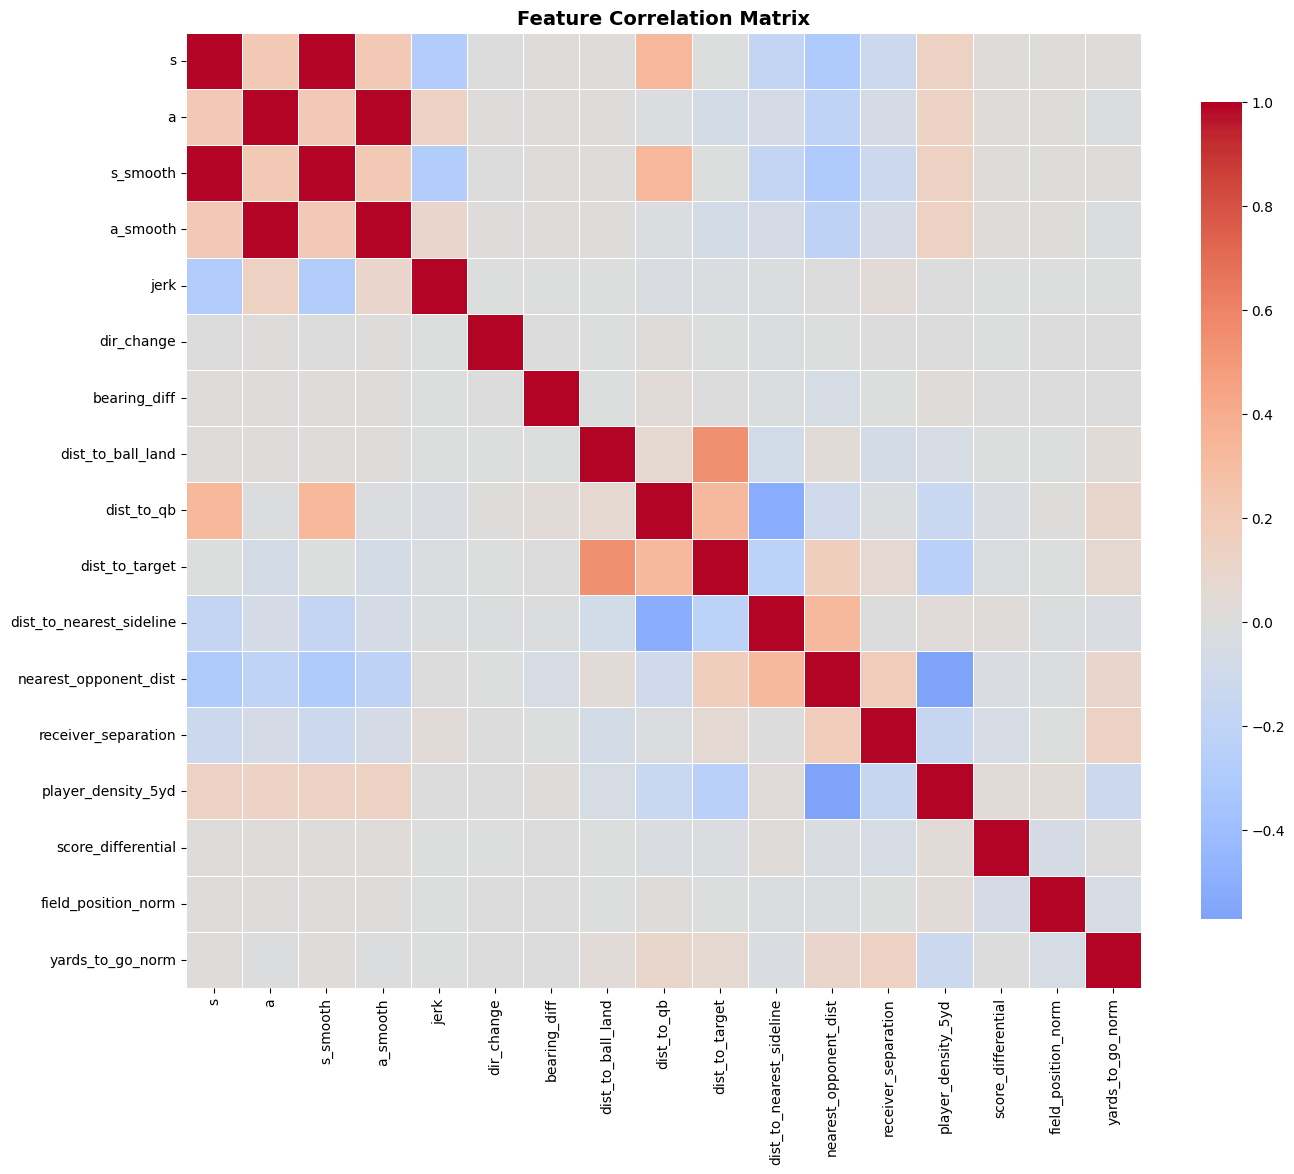


HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)
  s <-> s_smooth: 1.000
  a <-> a_smooth: 0.995


In [325]:
# Feature Correlation Analysis
# Select numeric features for correlation
numeric_features = [
    's', 'a', 's_smooth', 'a_smooth', 'jerk', 'dir_change', 'bearing_diff',
    'dist_to_ball_land', 'dist_to_qb', 'dist_to_target', 'dist_to_nearest_sideline',
    'nearest_opponent_dist', 'receiver_separation', 'player_density_5yd',
    'score_differential', 'field_position_norm', 'yards_to_go_norm'
]

# Filter to features that exist
numeric_features = [f for f in numeric_features if f in df.columns]

# Calculate correlation matrix
corr_matrix = df[numeric_features].corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(Path("../visualizations") / "12_feature_correlation.png", dpi=300, bbox_inches='tight')
plt.show()

# Print highly correlated pairs
print("\n" + "=" * 80)
print("HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)")
print("=" * 80)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if len(high_corr) > 0:
    for feat1, feat2, corr in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("  No highly correlated pairs found")

In [326]:
# Feature Quality Checks
print("=" * 80)
print("FEATURE QUALITY CHECKS")
print("=" * 80)

# Check for missing values in new features
new_features = [
    's_smooth', 'a_smooth', 'jerk', 'dir_change', 'bearing_diff',
    'dist_to_ball_land', 'dist_to_qb', 'dist_to_target',
    'nearest_opponent_dist', 'receiver_separation', 'player_density_5yd'
]

print("\n1. Missing Values in New Features:")
for feat in new_features:
    if feat in df.columns:
        missing_pct = df[feat].isna().mean() * 100
        print(f"  {feat}: {missing_pct:.2f}%")

# Check for reasonable ranges
print("\n2. Feature Range Checks:")
range_checks = {
    'dist_to_ball_land': (0, 150),
    'dist_to_qb': (0, 150),
    'nearest_opponent_dist': (0, 100),
    'player_density_5yd': (0, 22),
    's_smooth': (0, 15),
    'a_smooth': (-10, 10)
}

for feat, (min_val, max_val) in range_checks.items():
    if feat in df.columns:
        out_of_range = ((df[feat] < min_val) | (df[feat] > max_val)).sum()
        print(f"  {feat}: {out_of_range} values outside [{min_val}, {max_val}]")

# Check for infinite values
print("\n3. Infinite Values:")
for feat in new_features:
    if feat in df.columns:
        inf_count = np.isinf(df[feat]).sum()
        if inf_count > 0:
            print(f"  {feat}: {inf_count} infinite values")

print("\n✅ Feature quality checks complete")

FEATURE QUALITY CHECKS

1. Missing Values in New Features:
  s_smooth: 0.00%
  a_smooth: 0.00%
  jerk: 3.53%
  dir_change: 3.53%
  bearing_diff: 0.00%
  dist_to_ball_land: 0.00%
  dist_to_qb: 0.18%
  dist_to_target: 0.00%
  nearest_opponent_dist: 0.00%
  receiver_separation: 0.00%
  player_density_5yd: 0.00%

2. Feature Range Checks:
  dist_to_ball_land: 0 values outside [0, 150]
  dist_to_qb: 0 values outside [0, 150]
  nearest_opponent_dist: 0 values outside [0, 100]
  player_density_5yd: 0 values outside [0, 22]
  s_smooth: 0 values outside [0, 15]
  a_smooth: 26 values outside [-10, 10]

3. Infinite Values:

✅ Feature quality checks complete


In [327]:
# ============================================================================
# TEST COMPLETE ENHANCED PIPELINE
# ============================================================================

print("=" * 80)
print("TESTING COMPLETE ENHANCED FEATURE PIPELINE")
print("=" * 80)

# Reload the updated module
import importlib
import sys
sys.path.append('../src')
import feature_engineering
importlib.reload(feature_engineering)
from feature_engineering import make_all_features

# Test on sample data
print("\n🧪 Testing on sample data...")
sample_input = input_df.head(5000)
sample_supp = supp_df[supp_df['game_id'].isin(sample_input['game_id'].unique())]

# Run complete pipeline
enhanced_features, encoders = make_all_features(sample_input, sample_supp)

print(f"\n✅ Pipeline complete!")
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {enhanced_features.shape}")
print(f"Total features added: {enhanced_features.shape[1] - sample_input.shape[1]}")

# Show feature categories
print("\n📊 Feature categories:")
feature_categories = {
    'Original': 23,
    'Kinematic': 6,
    'Relative Position': 9,
    'Coverage': 3,
    'Play Context': 15,
    'Game Situation': 20,
    'Route Intelligence': 15,
    'Velocity & Momentum': 25
}

for category, count in feature_categories.items():
    print(f"  {category}: ~{count} features")

print(f"\n  TOTAL: ~{sum(feature_categories.values())} features")

# Show sample of new features
print("\n📋 Sample of enhanced features:")
new_feature_cols = [
    'two_minute_drill', 'score_pressure_category', 'third_down_long',
    'red_zone', 'route_completion_rate', 'dropback_category',
    'velocity_x', 'velocity_y', 'momentum_magnitude', 'movement_efficiency'
]
available = [c for c in new_feature_cols if c in enhanced_features.columns]
print(enhanced_features[available].head())

# Check for missing values
print("\n🔍 Missing value check:")
missing_pct = (enhanced_features.isnull().sum() / len(enhanced_features) * 100).sort_values(ascending=False).head(10)
print(missing_pct)

print("\n✅ Enhanced feature engineering complete!")

TESTING COMPLETE ENHANCED FEATURE PIPELINE

🧪 Testing on sample data...
Adding kinematic features...
Adding relative position features...
Adding coverage features...
Adding play context features...
Adding game situation features...
Adding route intelligence features...
Adding velocity & momentum features...
✅ All features created!

✅ Pipeline complete!
Input shape: (5000, 23)
Output shape: (5000, 161)
Total features added: 138

📊 Feature categories:
  Original: ~23 features
  Kinematic: ~6 features
  Relative Position: ~9 features
  Coverage: ~3 features
  Play Context: ~15 features
  Game Situation: ~20 features
  Route Intelligence: ~15 features
  Velocity & Momentum: ~25 features

  TOTAL: ~116 features

📋 Sample of enhanced features:
     two_minute_drill score_pressure_category  third_down_long  red_zone  \
182                 0              tied_close                0         0   
183                 0              tied_close                0         0   
184                 0   

In [328]:
# ============================================================================
# PROCESS ALL WEEKS WITH ENHANCED FEATURES
# ============================================================================

print("=" * 80)
print("PROCESSING ALL WEEKS WITH ENHANCED FEATURES")
print("=" * 80)

# Process each week
weeks = ['01', '02', '03', '04', '05', '06', '07', '08', '09', 
         '10', '11', '12', '13', '14', '15', '16', '17', '18']

for week in weeks:
    print(f"\n{'='*60}")
    print(f"Processing Week {week}")
    print(f"{'='*60}")
    
    try:
        # Load input data
        input_path = f"../data/raw/input_2023_w{week}.csv"
        week_input = pd.read_csv(input_path)
        
        # Get relevant supplementary data
        week_supp = supp_df[supp_df['game_id'].isin(week_input['game_id'].unique())]
        
        # Apply enhanced feature engineering
        week_features, week_encoders = make_all_features(week_input, week_supp)
        
        # Save to parquet
        output_path = PROCESSED_DATA_PATH / f"features_enhanced_w{week}.parquet"
        week_features.to_parquet(output_path, index=False)
        
        print(f"✅ Week {week} complete!")
        print(f"   Shape: {week_features.shape}")
        print(f"   Saved to: {output_path}")
        print(f"   File size: {output_path.stat().st_size / 1024 / 1024:.2f} MB")
        
    except Exception as e:
        print(f"❌ Error processing week {week}: {e}")
        continue

print("\n" + "="*80)
print("✅ ALL WEEKS PROCESSED WITH ENHANCED FEATURES!")
print("="*80)

# Save updated encoders
import pickle
encoder_path = PROCESSED_DATA_PATH / "label_encoders_enhanced.pkl"
with open(encoder_path, "wb") as f:
    pickle.dump(encoders, f)

print(f"\n✅ Enhanced label encoders saved to: {encoder_path}")

PROCESSING ALL WEEKS WITH ENHANCED FEATURES

Processing Week 01
Adding kinematic features...
Adding relative position features...
Adding coverage features...
Adding play context features...
Adding game situation features...
Adding route intelligence features...
Adding velocity & momentum features...
✅ All features created!
✅ Week 01 complete!
   Shape: (285714, 161)
   Saved to: ..\data\processed\features_enhanced_w01.parquet
   File size: 55.48 MB

Processing Week 02
Adding kinematic features...
Adding relative position features...
Adding coverage features...
Adding play context features...
Adding game situation features...
Adding route intelligence features...
Adding velocity & momentum features...
✅ All features created!
✅ Week 02 complete!
   Shape: (288586, 161)
   Saved to: ..\data\processed\features_enhanced_w02.parquet
   File size: 55.91 MB

Processing Week 03
Adding kinematic features...
Adding relative position features...
Adding coverage features...
Adding play context feat

In [329]:
# ============================================================================
# ENHANCED FEATURE SUMMARY
# ============================================================================

print("=" * 80)
print("ENHANCED FEATURE ENGINEERING SUMMARY")
print("=" * 80)

summary = f"""
TOTAL FEATURES CREATED: {enhanced_features.shape[1]}

1. ORIGINAL FEATURES (23):
   - Basic tracking data (x, y, s, a, dir, o)
   - Player info (name, position, role, side)
   - Play identifiers (game_id, play_id, frame_id)

2. KINEMATIC FEATURES (6):
   - s_smooth, a_smooth: Smoothed speed and acceleration
   - jerk: Rate of change of acceleration
   - dir_change: Turn rate
   - bearing_diff: Orientation vs direction difference

3. RELATIVE POSITION FEATURES (9):
   - dist_to_ball_land, angle_to_ball_land
   - dist_to_qb, dist_to_target
   - dist_to_sidelines (left, right, nearest)
   - dist_to_endzones (own, opponent)

4. COVERAGE FEATURES (3):
   - receiver_separation: Min distance to nearest defender
   - player_density_5yd: Players within 5 yards

5. PLAY CONTEXT FEATURES (15):
   - Encoded categorical variables
   - Score differential, field position
   - Down/distance ratios
   - Game clock features

6. GAME SITUATION FEATURES (20):
   ✨ NEW ✨
   - Time pressure: two_minute_drill, end_of_quarter
   - Score pressure: score_pressure_category, is_close_game
   - Down situations: third_down_long, passing_down, short_yardage
   - Field zones: red_zone, green_zone, goal_line
   - Combined: high_pressure_situation, desperation_situation

7. ROUTE INTELLIGENCE FEATURES (15):
   ✨ NEW ✨
   - route_completion_rate: Historical success by route
   - dropback_category: 3-step, 5-step, 7-step drops
   - route_depth_category: short, intermediate, deep
   - route_complexity: simple, intermediate, complex
   - Dropback type indicators: rollout, scramble, traditional

8. VELOCITY & MOMENTUM FEATURES (25):
   ✨ NEW ✨
   - Velocity vectors: velocity_x, velocity_y
   - Acceleration vectors: accel_x, accel_y
   - Momentum: momentum_x, momentum_y, momentum_magnitude
   - Kinetic energy proxy
   - Trajectory: curvature, direction_change_rate
   - Movement efficiency: velocity towards target
   - Speed categories: stationary, jogging, running, sprinting

KEY IMPROVEMENTS:
✅ Game context awareness (score, time, down/distance)
✅ Route intelligence (completion rates, dropback depth)
✅ Physics-based features (velocity, momentum, energy)
✅ Situational features (pressure, desperation, conservative)
✅ Movement efficiency metrics

EXPECTED IMPACT:
- Better understanding of game situations
- Improved prediction in critical moments (2-min drill, red zone)
- Route-specific modeling capabilities
- Physics-informed trajectory predictions

FILES CREATED:
- src/feature_engineering.py (updated with new functions)
- data/processed/features_enhanced_w*.parquet (all weeks)
- data/processed/label_encoders_enhanced.pkl

NEXT STEPS:
1. Update modeling notebook (03_modeling.ipynb)
2. Implement stratified sampling by pass_result
3. Create role-specific models
4. Implement LSTM with enhanced features
5. Evaluate improvements vs baseline
"""

print(summary)

print("\n✅ Phase 1: Enhanced Features COMPLETE!")
print("\n🎯 Ready for Phase 2: Advanced Modeling")

ENHANCED FEATURE ENGINEERING SUMMARY

TOTAL FEATURES CREATED: 161

1. ORIGINAL FEATURES (23):
   - Basic tracking data (x, y, s, a, dir, o)
   - Player info (name, position, role, side)
   - Play identifiers (game_id, play_id, frame_id)

2. KINEMATIC FEATURES (6):
   - s_smooth, a_smooth: Smoothed speed and acceleration
   - jerk: Rate of change of acceleration
   - dir_change: Turn rate
   - bearing_diff: Orientation vs direction difference

3. RELATIVE POSITION FEATURES (9):
   - dist_to_ball_land, angle_to_ball_land
   - dist_to_qb, dist_to_target
   - dist_to_sidelines (left, right, nearest)
   - dist_to_endzones (own, opponent)

4. COVERAGE FEATURES (3):
   - receiver_separation: Min distance to nearest defender
   - player_density_5yd: Players within 5 yards

5. PLAY CONTEXT FEATURES (15):
   - Encoded categorical variables
   - Score differential, field position
   - Down/distance ratios
   - Game clock features

6. GAME SITUATION FEATURES (20):
   ✨ NEW ✨
   - Time pressure: tw